# Fluxonium GDS

In [1]:
import gdspy

import numpy as np
import ruamel.yaml as yaml
import qnldraw as qd
import qnldraw.junction as qj
import matplotlib.pyplot as plt
from qnldraw import shapes, components, Chip
from qnldraw.components import Component

from qnldraw.junction import JunctionArray
from qnldraw.junction import JunctionLead

from typing import Iterable
# import gdspy
# import numpy as np

# import ruamel.yaml as yaml
import os

# import qnldraw as qd
# import qnldraw.junction as qj

from copy import deepcopy
from itertools import product
from pathlib import Path

from qnldraw import shapes, paths, components, Angle, Params
from qnldraw.shapes import Rectangle
from qnldraw.paths import Trace

In [2]:
class JunctionArray(components.Component):
    __draw__ = True
    
    def draw(self, n, overlap, wire, undercut):
        jx, jy = overlap
        wx, wy = wire
        
        spacing = jy + wy
        
        positions = (np.arange(n) - (n-1)/2)*spacing
        
        undercut_a, undercut_b = undercut #creating variable undercut
        
        for y in positions:
            junction_rect = shapes.Rectangle(jx, jy).translate(0, y)
            undercuts = [
                shapes.Rectangle(undercut_b, jy, 'right', layer=2).translate(-jx/2, y),
                shapes.Rectangle(undercut_b, jy, 'left', layer=2).translate(jx/2, y)
            ]
            
            self.add(junction_rect)
            self.add(undercuts)
            
        for i, y in enumerate(positions[:-1]):
            wire_rect = shapes.Rectangle(wx, wy, 'bottom').translate(0, y + 0.5*jy)
            undercuts = shapes.Rectangle(
                undercut_a, wy, 'bottom left' if i%2 else 'bottom right', layer=1
            ).translate(
                (2*(i%2) - 1)*wx/2, y + 0.5*jy
            )

            self.add(wire_rect)
            self.add(undercuts)
            
        nodes = {
            'wire1': np.array((0, positions[-1] + 0.5*jy)),
            'wire2': np.array((0, positions[0] - 0.5*jy))
        }
        return nodes
    
#small junction with variable overlaye/undercut size

class Junction_Small(components.Component):
    __draw__ = True
    
    def draw(self, lead, undercut):
        lead_x, lead_y = lead
        undercut_x, undercut_y = undercut

        leads = [
            shapes.Rectangle(lead_x, lead_y). translate((lead_x+undercut_x)/2,-lead_y),
            shapes.Rectangle(lead_x, lead_y). translate(-(lead_x+undercut_x)/2,-lead_y)
        ]
        undercuts = shapes.Rectangle(undercut_x, lead_y, layer=1). translate(0,-lead_y)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
     
class Junction_Small_dolan(components.Component):
    __draw__ = True

    def draw(self, lead, finger, undercut):
        left_lead_x, left_lead_y, right_lead_x, right_lead_y = lead
        finger_x, finger_y = finger
        undercut_x, undercut_y = undercut
        
        leads = [
            shapes.Rectangle(right_lead_x, right_lead_y).translate((right_lead_x+undercut_x)/2,-(undercut_y/3-right_lead_y/2+0.1)),
            shapes.Rectangle(left_lead_x, left_lead_y).translate(-(left_lead_x+undercut_x)/2,(undercut_y/3-left_lead_y/2-0.1)),
            shapes.Rectangle(finger_x, finger_y).translate(undercut_x/2+finger_x/2,0)
        ]
        undercuts = shapes.Rectangle(undercut_x, undercut_y, layer=1)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
    

class JunctionLead(components.Component):#narrow leads between antenna and junction
    
    '''4 undercuts for the two leads'''
    
    __draw__ = True

    def draw(self, offset, lead, undercut, cut_parameter_L, cut_parameter_R):
        lead_x, lead_y = lead
        left_undercut_x, left_undercut_y, right_undercut_x, right_undercut_y = undercut
        offset_x, offset_y = offset
        base_left = 0.267
        base_right = 0.067
        leads = [
            shapes.Rectangle(lead_x, lead_y). translate(offset_x, -offset_y),
            shapes.Rectangle(lead_x, lead_y). translate(-offset_x, -offset_y)
        ]
        undercuts = [
            shapes.Rectangle(left_undercut_x, base_left, layer=1).translate(offset_x/2-lead_x/2-0.3, -offset_y+0.5-base_left/2),
            shapes.Rectangle(left_undercut_x, 1-base_left-cut_parameter_L, layer=1).translate(offset_x/2-lead_x/2-0.3, -offset_y-0.5+(1-base_left-cut_parameter_L)/2),
            shapes.Rectangle(right_undercut_x, 1-base_right-cut_parameter_R, layer=1).translate(-(offset_x/2-lead_x/2-0.3), -offset_y+0.5-(1-base_right-cut_parameter_R)/2),
            shapes.Rectangle(right_undercut_x, base_right, layer=1).translate(-(offset_x/2-lead_x/2-0.3), -offset_y-0.5+base_right/2)
        ]
        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (left_undercut_x/2, 0),
            'right': (right_undercut_x/2, 0)
        }
        return nodes
    
class JunctionLead_ArrOnly(components.Component):#narrow leads between antenna and junction
    
    '''without cuts into lead undercuts'''
    
    __draw__ = True

    def draw(self, offset, lead, undercut):
        lead_x, lead_y = lead
        left_undercut_x, left_undercut_y, right_undercut_x, right_undercut_y = undercut
        offset_x, offset_y = offset
        base_left = 0.267
        base_right = 0.067
        leads = [
            shapes.Rectangle(lead_x, lead_y). translate(offset_x, -offset_y),
            shapes.Rectangle(lead_x, lead_y). translate(-offset_x, -offset_y)
        ]
        undercuts = [
            shapes.Rectangle(left_undercut_x, 1, layer=1).translate(offset_x/2-lead_x/2-0.3, -offset_y),
            #shapes.Rectangle(left_undercut_x, 1-base_left-cut_parameter_L, layer=1).translate(offset_x/2-lead_x/2-0.3, -offset_y-0.5+(1-base_left-cut_parameter_L)/2),
            #shapes.Rectangle(right_undercut_x, 1-base_right-cut_parameter_R, layer=1).translate(-(offset_x/2-lead_x/2-0.3), -offset_y+0.5-(1-base_right-cut_parameter_R)/2),
            shapes.Rectangle(right_undercut_x, 1, layer=1).translate(-(offset_x/2-lead_x/2-0.3), -offset_y)
        ]
        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (left_undercut_x/2, 0),
            'right': (right_undercut_x/2, 0)
        }
        return nodes
    
class AntennaSymmetric(components.Component): #antenna pads
    __draw__ = True
    
    def draw(self, pad, lead, gap, undercut):
        pad_x, pad_y = pad
        lead_x, lead_y = lead
        
        antenna = [
            shapes.Rectangle(pad_x, pad_y). translate((gap/2+lead_x+pad_x/2), -4.5),
            shapes.Rectangle(pad_x, pad_y). translate(-(gap/2+lead_x+pad_x/2),-4.5),
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,-4.5),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,-4.5)
        ]
        undercuts = [
            shapes.Rectangle(undercut, pad_y, layer=1).translate((gap/2+lead_x+pad_x+undercut/2),-4.5),
            shapes.Rectangle(undercut, pad_y, layer=1).translate(-(gap/2+lead_x+pad_x+undercut/2),-4.5),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate(-(gap/2+lead_x-undercut/2),+15-4.5),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate(-(gap/2+lead_x-undercut/2),-15-4.5),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate((gap/2+lead_x-undercut/2),+15-4.5),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate((gap/2+lead_x-undercut/2),-15-4.5),
#             shapes.Rectangle(undercut, lead_y-1, layer=1).translate((gap-undercut)/2,+0.5-4.5),
#             shapes.Rectangle(undercut, lead_y-1, layer=1).translate(-(gap-undercut)/2,+0.5-4.5)
            
        ]
        self.add(antenna)
        self.add(undercuts)
        nodes = {
            'left': (-gap/2,0),
            'right': (gap/2,0)
        }
        return nodes
    
class AntennaLead(components.Component): #antenna lead
    __draw__ = True
    
    def draw(self,lead, gap, undercut):
        lead_x, lead_y = lead
        
        Leadantenna = [
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,0),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,0)
        ]
        undercuts = [
            shapes.Rectangle(undercut, lead_y-1, layer=1).translate((gap-undercut)/2,+0.5),
            shapes.Rectangle(undercut, lead_y-1, layer=1).translate(-(gap-undercut)/2,+0.5)
            
        ]
        self.add(Leadantenna)
        self.add(undercuts)
        nodes = {
            'left': (-gap/2,0),
            'right': (gap/2,0)
        }
        return nodes
    
    
class vertical_finger_small(components.Component):
    __draw__ = True

    def draw(self, jjsize, undercut):
      
        jj_x, jj_y = jjsize
        undercut_x, undercut_y = undercut
        
        leads = [
            shapes.Rectangle(jj_x, undercut_y).translate(undercut_x/2+jj_x/2,0)
        ]
        undercuts = shapes.Rectangle(undercut_x, undercut_y, layer=1)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
    
class mask_square(components.Component):
    __draw__ = True

    def draw(self, size):
      
        x_dim, y_dim = size
        
        square = [
            shapes.Rectangle(x_dim, y_dim, layer = 6)#.translate(-x_dim/2, -y_dim/2)
        ]
        self.add(square)
        nodes = {
            'center': (x_dim/2, y_dim/2),
            'left' : (-x_dim/2,0),
            'right': (x_dim/2,0)
        }
        return nodes

class JunctionLead_SingleArr(components.Component):#narrow leads between antenna and junction
    
    '''without cuts into lead undercuts'''
    
    __draw__ = True

    def draw(self, offset, lead, undercut, left_offset):
        lead_x, lead_y = lead
        left_undercut_x, left_undercut_y, right_undercut_x, right_undercut_y = undercut
        offset_x, offset_y = offset

        leads = [
            shapes.Rectangle(lead_x, lead_y). translate(offset_x, -offset_y),
            shapes.Rectangle(lead_x, lead_y). translate(-offset_x, -offset_y-left_offset)
        ]
        undercuts = [
            shapes.Rectangle(left_undercut_x, 1, layer=1).translate(-3.2, -offset_y),
            #shapes.Rectangle(left_undercut_x, 1-base_left-cut_parameter_L, layer=1).translate(offset_x/2-lead_x/2-0.3, -offset_y-0.5+(1-base_left-cut_parameter_L)/2),
            #shapes.Rectangle(right_undercut_x, 1-base_right-cut_parameter_R, layer=1).translate(-(offset_x/2-lead_x/2-0.3), -offset_y+0.5-(1-base_right-cut_parameter_R)/2),
            shapes.Rectangle(right_undercut_x, 1, layer=1).translate(3.2, -offset_y-left_offset)
        ]
        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (left_undercut_x/2, 0),
            'right': (right_undercut_x/2, 0)
        }
        return nodes

class AntennaAsymmetric(components.Component): #antenna pads
    __draw__ = True
    
    def draw(self, pad, lead, gap, undercut, left_offset):
        pad_x, pad_y = pad
        lead_x, lead_y = lead
        
        antenna = [
            shapes.Rectangle(pad_x, pad_y). translate((gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(pad_x, pad_y). translate(-(gap/2+lead_x+pad_x/2),-left_offset),
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,0),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,-left_offset)
        ]
        undercuts = [
            shapes.Rectangle(undercut, pad_y, layer=1).translate((gap/2+lead_x+pad_x+undercut/2),0),
            shapes.Rectangle(undercut, pad_y, layer=1).translate(-(gap/2+lead_x+pad_x+undercut/2),-left_offset),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate(-(gap/2+lead_x-undercut/2),+15-left_offset),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate(-(gap/2+lead_x-undercut/2),-15-left_offset),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate((gap/2+lead_x-undercut/2),+15),
            shapes.Rectangle(undercut, pad_y/2-5, layer=1).translate((gap/2+lead_x-undercut/2),-15),
            shapes.Rectangle(undercut, lead_y-1, layer=1).translate((gap-undercut)/2,+0.5),
            shapes.Rectangle(undercut, lead_y-1, layer=1).translate(-(gap-undercut)/2,+0.5-left_offset)
            
        ]
        self.add(antenna)
        self.add(undercuts)
        nodes = {
            'left': (-gap/2,0),
            'right': (gap/2,0)
        }
        return nodes

# Single Qubit

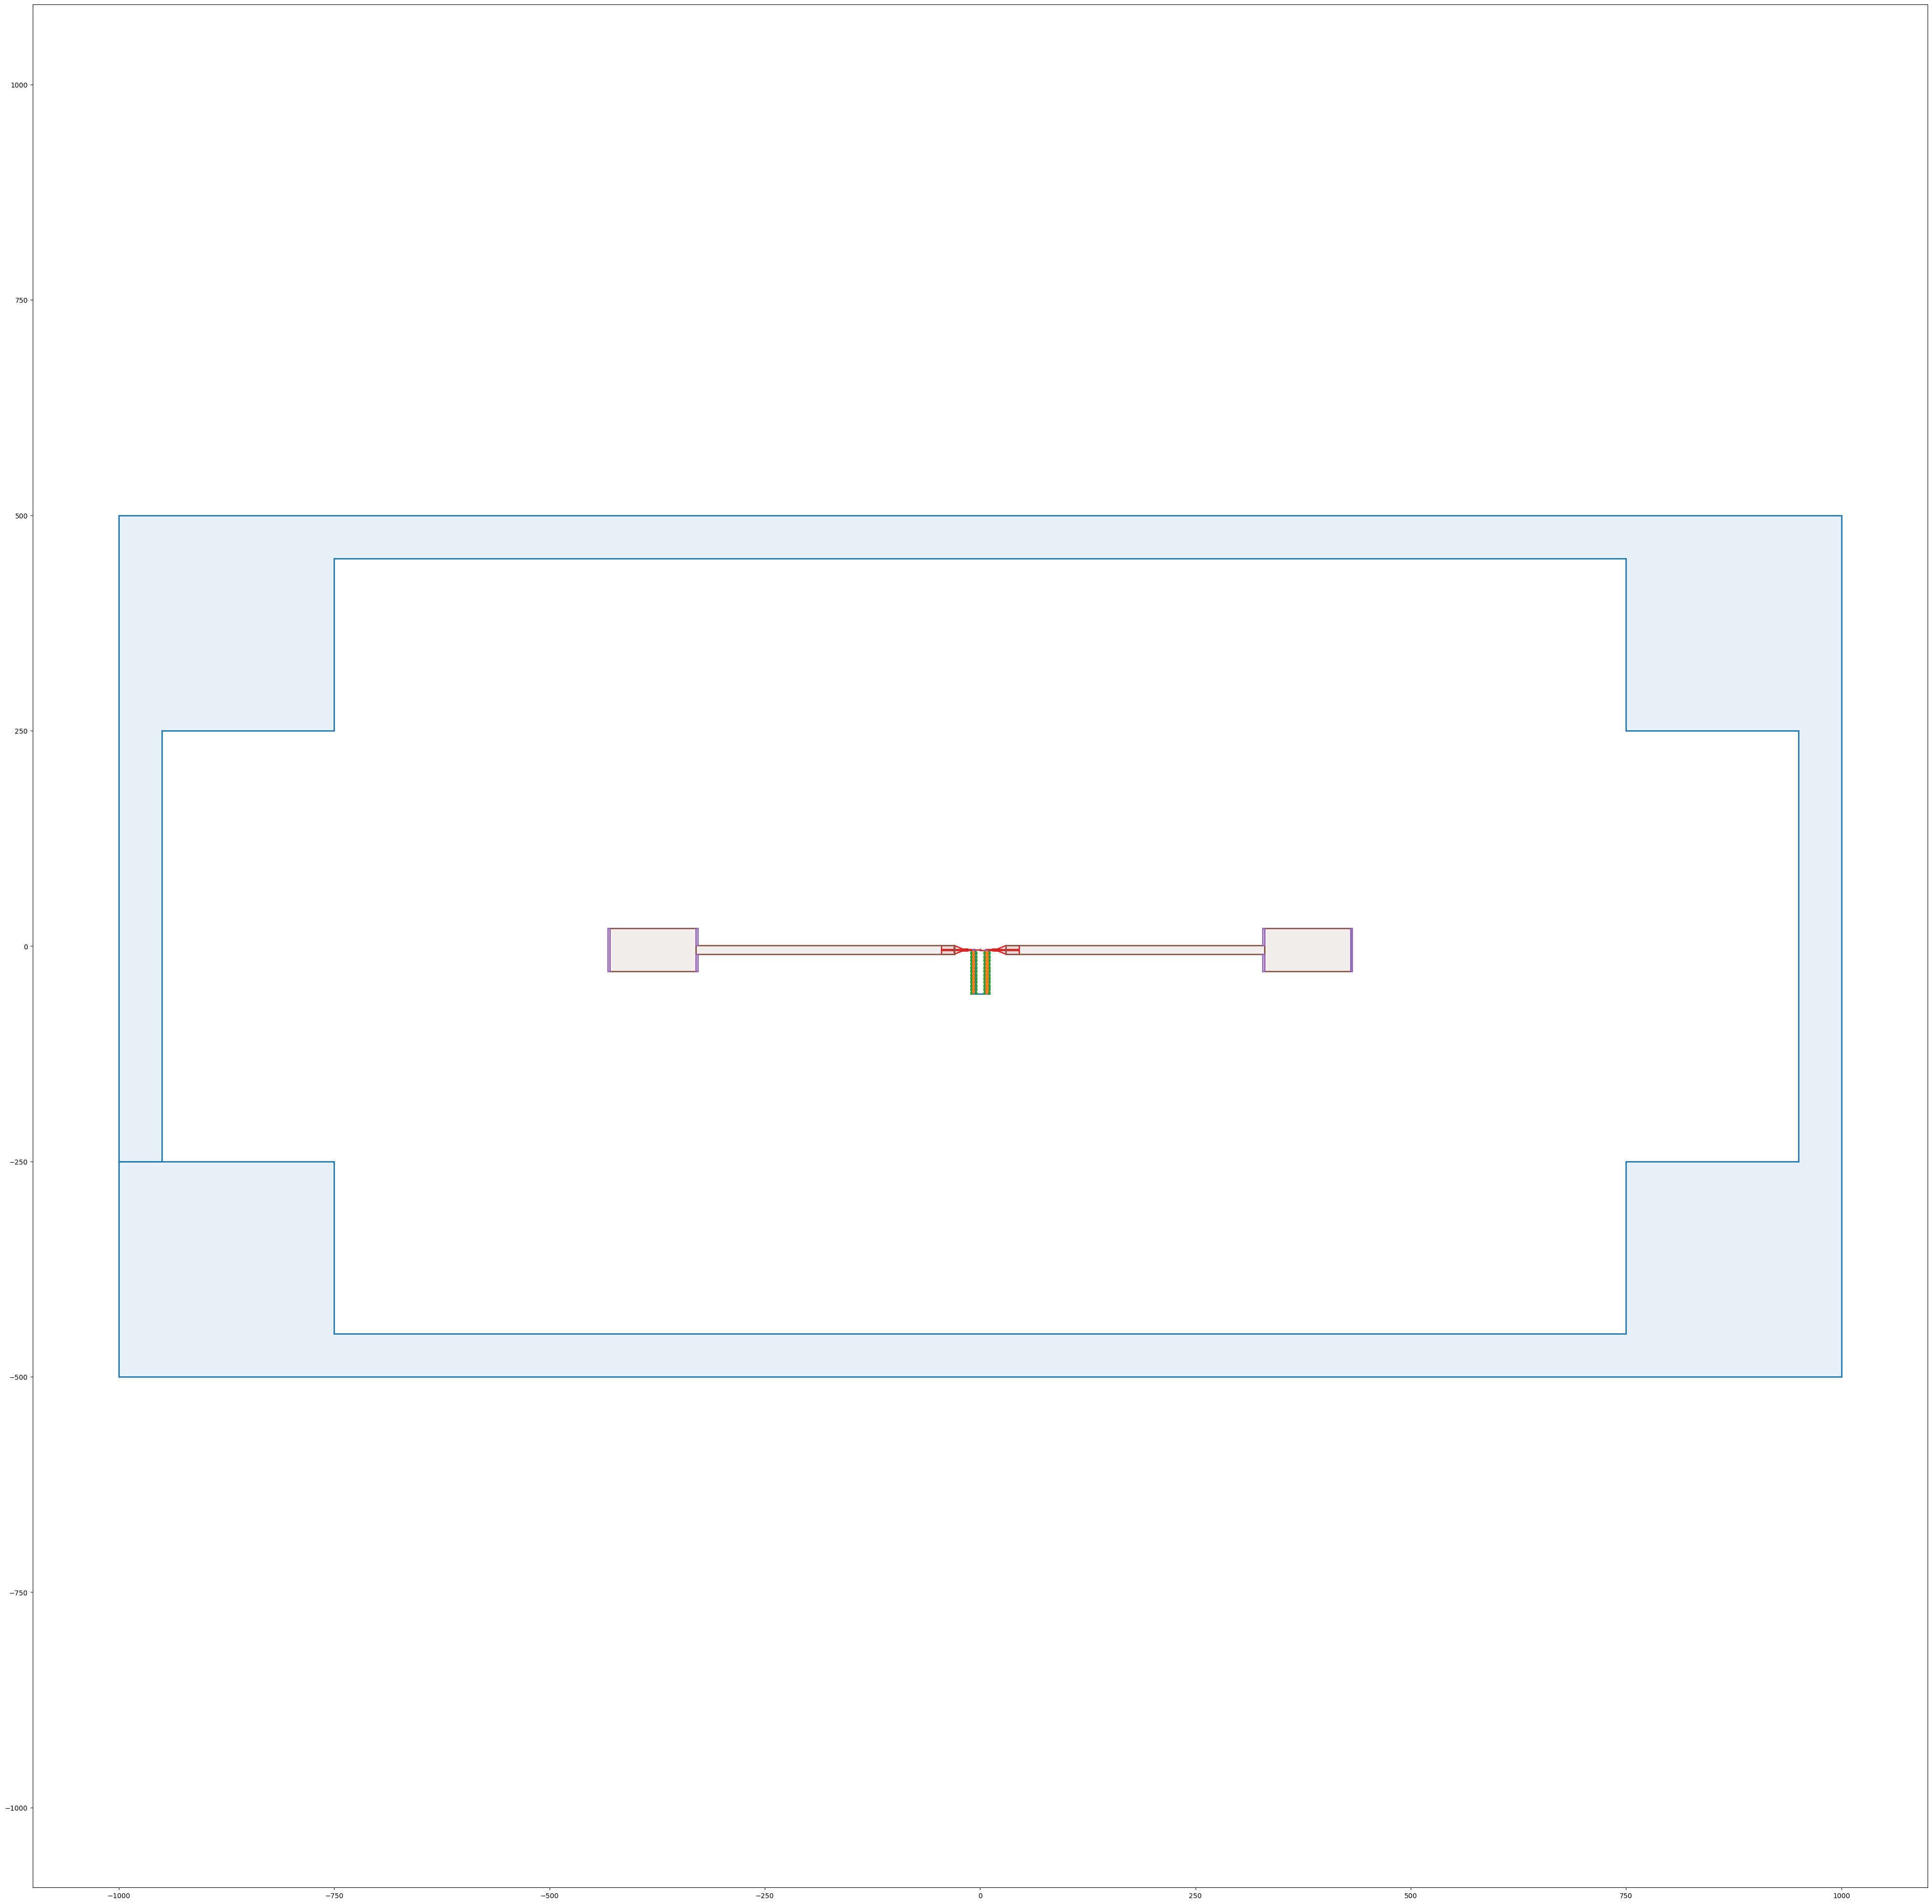

In [3]:
if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    chip = qd.Chip(size = (2000,1000))
    with open('parameters-300nm.yaml', 'r') as f:
        params = qd.Params(yaml.load(f, yaml.CSafeLoader))
    
    #antenna
    pad = (100,50)
    antenna_lead = (300, 10)
    gap = 60
    undercut_antenna = 2
    undercut_leadantenna = 2
    pad_spacing = 80
    lead_horizontal_separation = 30
    lead_vertical_separation = 10
    
    lead_params = params['leads']
    lead_params.update({
        'total_length': pad_spacing/2 + lead_params['pad_overlap'] - lead_horizontal_separation/2,
        'extension': lead_params['inner.width']/2 - 1/2,
    })

    leads = qj.JunctionLead(**lead_params)
#     bandage = qj.

    lx = lead_horizontal_separation
    ly = (1 + lead_vertical_separation)/2

    left_lead = leads.place((-lx / 2, -4.5), node='inner_lead')
    right_lead = leads.place((lx / 2, -4.5), node='inner_lead', mirror='y')
    
        ##antenna functions 
    
    AntennaLeads = AntennaLead(antenna_lead, gap, undercut_leadantenna)
    antenna = AntennaSymmetric(pad, antenna_lead, gap, undercut_antenna)
    
    #array
    n =  100
    overlap = params['evaporation.junctions.overlap'] # lx, ly, junction size
    wire = params['evaporation.junctions.wire']   # lx, ly, connecting piece between junctions
    undercut = params['evaporation.junctions.undercut']     # undercut for wires in 2d
    array_gap = overlap[0] + 10
    offset_array = antenna_lead[1]-4 #move the array in -y direction
     
        #array functions
    array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
    array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
    array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
   
    
    #small junction dolan + leads
    '''this is where we change 0.15 and want the undercut to respond'''
    cut_parameter_L = 0.08
    cut_parameter_R = 0.08
    junction_lead = [7.0, cut_parameter_L, 8, cut_parameter_R] #left and right lead sizes in x and y
    junction_finger = [0.26, 0.8]
    junction_undercut = [0.4,1]
    offset_jj = [-0.4,-4.5]
    
        ## dolan functions
    jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
    junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
    
        ##lead connecting junction region to antenna
    j_lead_dim = [37.9, 1] # total lead x and y
    j_lead_undercut=[0.4,1,0.4,1] # total x and y undercut
    offset = [25.6,4.5] # gap between leads
    jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, cut_parameter_L, cut_parameter_R) 
    
        ##lead connecting arrays
    array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
    
    
    #finger leads:
    finger_size = [0.4,0.03]
    finger_undercut = [.7,1.0]
    vertical_finger = vertical_finger_small(finger_size, finger_undercut)
    finger1=vertical_finger.place((-array_gap/2-0.4,1-offset_array+wire[1]*2))
    finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
    
   
   
    #fig = qd.plot([array1])
    #fig = qd.plot(antenna)
    #fig = qd.plot(array_lead)
    #fig = qd.plot(junction_small_2, figsize=(5,5), axis=True, grid=False)
    #fig = qd.plot(junction_small, figsize=(5,5), axis=True, grid=False)
    #fig = qd.plot(vertical_finger, figsize=(20,20), axis=True, grid=False)
    
    #Defining dose layers
    dose_layers = [0, 1]
    dose_layer_undercut = [2]
    dose_layer_jun = [3, 4]
    dose_layer_ant = [5, 4]
    dose_layer_align = [6]
    evap_layers = params['evaporation.layers']
    
    #alignment square
    square_size = [520, 520]
    sqr = mask_square(square_size)
    chip.add_component([left_lead, right_lead], 'leads', layers=dose_layer_jun)
    chip.add_component(antenna, cid = 'antenna', layers=dose_layer_ant)
    chip.add_component(array1, cid = 'array1', layers=dose_layers)
    chip.add_component(array2, cid = 'array2', layers=dose_layers)
    chip.add_component(array_lead, cid = 'array_lead', layers=dose_layers)
    chip.add_component(junction_dolan, cid = 'junction', layers=dose_layer_jun)
    chip.add_component(jjlead, cid = 'jjlead', layers=dose_layer_jun)
    #chip.add_component(junction_small, cid = 'junction_2', layers=dose_layers)
    chip.add_component(finger1, cid = "finger1", layers=dose_layer_jun)
    chip.add_component(finger2, cid = "finger2", layers=dose_layer_jun)
    mask = chip.render(name = 'fluxonium', draw_border = True)
    

    
    fig = qd.plot(mask[0], figsize=(50,50), axis=True, grid=False)
    
    #fig = qd.plot(mask[1], figsize=(20,20), axis=True, grid=False)
    #fig = qd.plot(mask[2], figsize=(20,20), axis=True, grid=False)
    #fig = qd.plot(mask[3], figsize=(20,20), axis=True, grid=False)
    
    ## Simulate Evaporation
    cells = chip.render(name='fluxonium', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_jun[0], 0)], )
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )

    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='fluxonium', draw_border=False)
    lib.write_gds('fluxonium_test_240917.gds', cells=cells)

In [4]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5,4]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 100

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8

            junction_finger[0] = 0.29
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.15#left and right lead sizes in x and y
            junction_lead[3] = 0.15
            junction_undercut[0] = 0.3
            junction_undercut[1] = 1
            n=100
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, 0.1-offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, 0.1-offset_array+wire[1]*2))
            
            junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
            left_lead.assign_layers(dose_layer_jun)
            right_lead.assign_layers(dose_layer_jun)
            antenna.assign_layers(dose_layer_ant)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr)
            f.add(jjlead)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
            f.add(junction_dolan)
#             f.add(antenna)
            f.add([left_lead, right_lead])
    
          
            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)]  + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)])
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('240726_flux_150_0p30.gds', cells=cells)
    

## no antenna

In [5]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
# dose_layer_ant = [5,4]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 100

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8

            junction_finger[0] = 0.28
            junction_finger[1] = 0.8
            junction_lead[1] = 0.1#left and right lead sizes in x and y
            junction_lead[3] = 0.15
            junction_undercut[0] = 0.5
            junction_undercut[1] = 1
            n=100
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -0.1-offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -0.1-offset_array+wire[1]*2))
            
            junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
            left_lead.assign_layers(dose_layer_jun)
            right_lead.assign_layers(dose_layer_jun)
            antenna.assign_layers(dose_layer_ant)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr)
            f.add(jjlead)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
            f.add(junction_dolan)
#             f.add(antenna)
            f.add([left_lead, right_lead])
    
          
            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)]  + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)])
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('zp_230503_F_L_A300_D100x100.gds', cells=cells)
    

## aray only

In [14]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
# dose_layer_ant = [5,4]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 100

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8
            n=100
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
#             jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
#             jj.assign_layers(dose_layer_jun)
            
#             junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
#             jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -0.1-offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -0.1-offset_array+wire[1]*2))
            
#             junction_dolan.assign_layers(dose_layer_jun)
#             jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
            left_lead.assign_layers(dose_layer_jun)
            right_lead.assign_layers(dose_layer_jun)
            antenna.assign_layers(dose_layer_ant)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr)
            f.add(jjlead)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
#             f.add(junction_dolan)
#             f.add(antenna)
            f.add([left_lead, right_lead])
    
          
            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)]  + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)])
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('zp_230503_array_A300.gds', cells=cells)
    

## Dolan only no antenna

In [16]:
#dolan finge[1]=0.15  ****

dose_layers = [0, 1]
# dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 500

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):

            junction_finger[0] = 0.35
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.3 #left and right lead sizes in x and y
            junction_lead[3] = 0.1
            junction_undercut[0] = 0.5
            junction_undercut[1] = 1
                
          
            
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)

            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            
            left_lead.assign_layers(dose_layers)
            right_lead.assign_layers(dose_layers)
          
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            f.add(jjlead)
            f.add(junction_dolan)
#             f.add(antenna)
#             f.add(sqr)
            f.add([left_lead, right_lead])

       
          
           

            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)])
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('zp_230410_Dolan_rasnmon.gds', cells=cells)
    

# Fluxonium qubit Small Spacing


In [22]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 100

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8

            junction_finger[0] = 0.4
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.3#left and right lead sizes in x and y
            junction_lead[3] = 0.1
            junction_undercut[0] = 0.3
            junction_undercut[1] = 1
            n=100
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
            
            junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr)
            f.add(jjlead)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
            f.add(junction_dolan)
#             f.add(antenna)
             
    
          
            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)]  + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('0823_flux_100_0p26_test.gds', cells=cells)
    

In [ ]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 4000
    dx = 500

    Nx = 1
    Ny = 8
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8

            junction_finger[0] = 0.28
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.1 #left and right lead sizes in x and y
            junction_lead[3] = 0.1
            junction_undercut[0] = 0.3
            junction_undercut[1] = 1
            n=100
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
            
            junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr)
            f.add(jjlead)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
            f.add(junction_dolan)
            f.add(antenna)
             
    
          
            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)] + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('0525_fluxonium_100p328.gds', cells=cells)


    

KeyError: (5, 0)

# Dolan only 

In [4]:
#dolan finge[1]=0.15  ****

dose_layers = [0, 1]
dose_layer_jun = [3, 4]
# dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 500

    Nx = 1
    Ny = 1
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):

            junction_finger[0] = 0.28
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.15 #left and right lead sizes in x and y
            junction_lead[3] = 0.1
            junction_undercut[0] = 0.5
            junction_undercut[1] = 1
                
          
            
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)

            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
        
               
          
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            f.add(jjlead)
            f.add(junction_dolan)
#             f.add(antenna)
            f.add(sqr)
            f.add([left_lead, right_lead])
       
          
           

            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)]  + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)])
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('zp_230410_Dolan_only_150_0p28.gds', cells=cells)
    

KeyError: (4, 0)

# Array only, n=100

In [37]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 500

    Nx = 1
    Ny = 4
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            
            undercut[1] = 0.8
                
            junction_finger[0] = 0.30
            junction_finger[1] = 0.8 
            junction_lead[1] = 0.15 #left and right lead sizes in x and y
            junction_lead[3] = 0.1
            junction_undercut[0] = 0.25
            junction_undercut[1] = 1
            n=100
                

                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
            
            #junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr) # something weird with layers here
            
        
            f.add(jjlead_arronly)
            f.add([array1, array2])
            f.add(array_lead)
            f.add(finger1)
            f.add(finger2)
            f.add(antenna)
        
            

            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)] + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('0525_ArrayOnly_100.gds', cells=cells)

# Array only, n=2

In [29]:
#4th dose test small spacing ****
dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 500

    Nx = 1
    Ny = 4
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            if row ==0:
                undercut[1] = 0.8
                
                junction_finger[0] = 0.30
                junction_finger[1] = 0.8 
                junction_lead[1] = 0.15 #left and right lead sizes in x and y
                junction_lead[3] = 0.1
                junction_undercut[0] = 0.25
                junction_undercut[1] = 1
                n=2
                

                
            if row ==1:
                undercut[1] = 0.8
                
                junction_finger[0] = 0.30
                junction_finger[1] = 0.8 
                junction_lead[1] = 0.15 #left and right lead sizes in x and y
                junction_lead[3] = 0.1
                junction_undercut[0] = 0.25
                junction_undercut[1] = 1
                n=2
                
               
            
            if row ==2:
                undercut[1] = 0.8
                
                junction_finger[0] = 0.30
                junction_finger[1] = 0.8 
                junction_lead[1] = 0.15 #left and right lead sizes in x and y
                junction_lead[3] = 0.1
                junction_undercut[0] = 0.25
                junction_undercut[1] = 1
                n=2
               
                
            if row ==3:
                undercut[1] = 0.8
                
                junction_finger[0] = 0.30
                junction_finger[1] = 0.8 
                junction_lead[1] = 0.15 #left and right lead sizes in x and y
                junction_lead[3] = 0.1
                junction_undercut[0] = 0.25
                junction_undercut[1] = 1
                n=2
                
                
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
            array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
            jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
            jj.assign_layers(dose_layer_jun)
            
            junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
            jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, junction_lead[1], junction_lead[3])
            jjlead_arronly = JunctionLead_ArrOnly(offset, j_lead_dim, j_lead_undercut)
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
            finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
            
            #junction_dolan.assign_layers(dose_layer_jun)
            jjlead.assign_layers(dose_layer_jun)
            jjlead_arronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
          #I get the correct layering when the "jj" and "junction_dolan" are commented out. but then I cannot make changes to the parameters (forexample change junction undercut)
                    
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            #f.add(sqr) # something weird with layers here
            
            if row ==0: 
                f.add(jjlead_arronly)
                f.add([array1, array2])
                f.add(array_lead)
                f.add(finger1)
                f.add(finger2)
                f.add(antenna)
             
                
            if row ==1: 
                f.add(jjlead_arronly)
                f.add([array1, array2])
                f.add(array_lead)
                f.add(finger1)
                f.add(finger2)
                f.add(antenna)
            
            if row ==2: 
                f.add(jjlead_arronly)
                f.add([array1, array2])
                f.add(array_lead)
                f.add(finger1)
                f.add(finger2)
                f.add(antenna)
                
            if row ==3: 
                f.add(jjlead_arronly)
                f.add([array1, array2])
                f.add(array_lead)
                f.add(finger1)
                f.add(finger2)
                f.add(antenna)
            

            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)] + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('0525_array_only_n2.gds', cells=cells)

# Single Array only

In [36]:
# superinductor resonator, single array/no dolan

dose_layers = [0, 1]
dose_layer_undercut = [2]
dose_layer_jun = [3, 4]
dose_layer_ant = [5]
dose_layer_align = [6] 

if  __name__ == '__main__':
    dy = 500
    dx = 500

    Nx = 1
    Ny = 4
    
    xs = dx*(np.arange(Nx) - 0.5*(Nx-1)) # X positions
    ys = dy*(np.arange(Ny) - 0.5*(Ny-1)) # Y positions

    chip = Chip(size=(70e3, 70e3))
                        
    for row, y in enumerate(ys): 
        for col, x in enumerate(xs):
            
            # parameter defintion
            undercut[1] = 0.8
            n=3 # length of arrays
            overlap = [3, 0.2]
            
            fingerheight = finger_undercut[1]
            leadheight = j_lead_dim[1]
            arrayheight=0.2 + 0.45*(n-1)
            left_lead_yoffset = arrayheight + fingerheight*2 + leadheight
            
            # define and place array
            array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
            array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
            
            # define leads
            jjlead_singlearronly = JunctionLead_SingleArr(offset, j_lead_dim, j_lead_undercut, left_lead_yoffset)
            
            # define and place fingers
            vertical_finger = vertical_finger_small(finger_size, finger_undercut)
            finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
            finger2=vertical_finger.place((-array_gap/2-0.4, -offset_array-wire[1]*2-arrayheight))
            
            #antenna params
            pad = (100,50)
            antenna_lead = (300, 10)
            gap = 80
            undercut_antenna = 2
            # define antenna
            antenna = AntennaAsymmetric(pad, antenna_lead, gap, undercut_antenna, left_lead_yoffset)
            
            # assign layers
            #jjlead.assign_layers(dose_layer_jun)
            jjlead_singlearronly.assign_layers(dose_layer_jun)
            vertical_finger.assign_layers(dose_layer_jun)
            antenna.assign_layers(dose_layer_ant)
            
            # alignment square
            square_size = [520, 520]
            sqr = mask_square(square_size)
            
            f = components.Component(name=f'fluxonium-{row}{col}')
            
            f.add(sqr) 
            f.add(jjlead_singlearronly)
            f.add(array1)
            f.add(finger1)
            f.add(finger2)
            f.add(antenna)

            chip.add_component(f.place((x, y)), layers=dose_layers)
         
    mask = chip.render(name='sweep-array', draw_border=False)

    cells = chip.render(name='sweep', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)] + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )
    
    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='sweep', draw_border=False)
    lib.write_gds('0525_Kerr_n3_3p0.gds', cells=cells)

In [4]:
if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    chip = qd.Chip(size = (2000,1000))
    with open('parameters-dose-check.yaml', 'r') as f:
        params = qd.Params(yaml.load(f, yaml.CSafeLoader))
    
    #antenna
    pad = (150,150)
    antenna_lead = (300, 10)
    gap = 80
    undercut_antenna = 2
    
        ##antenna functions 
    
    antenna = AntennaSymmetric(pad, antenna_lead, gap, undercut_antenna)
    
    #array
    n1 =  100
    overlap = params['evaporation.junctions.overlap'] # lx, ly, junction size
    wire = params['evaporation.junctions.wire']   # lx, ly, connecting piece between junctions
    undercut = params['evaporation.junctions.undercut']     # undercut for wires in 2d
    array_gap = overlap[0] + 10
    offset_array = antenna_lead[1]-4 #move the array in -y direction
    n2=200
    overlap = params['evaporation.junctions.overlap'] # lx, ly, junction size
    wire = params['evaporation.junctions.wire']   # lx, ly, connecting piece between junctions
    undercut = params['evaporation.junctions.undercut']     # undercut for wires in 2d
    array_gap = overlap[0] + 10
    offset_array = antenna_lead[1]-4 #move the array in -y direction
    
        #array functions
    array1 = JunctionArray(n1=n1, overlap=overlap, wire=wire, undercut=undercut)
    array_1 = array1.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
    array2 = JunctionArray(n2=n2, overlap=overlap, wire=wire, undercut=undercut)
    array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
   
    
    #small junction dolan + leads
    '''this is where we change 0.15 and want the undercut to respond'''
    cut_parameter_L = 0.08
    cut_parameter_R = 0.08
    junction_lead = [7.0, cut_parameter_L, 8, cut_parameter_R] #left and right lead sizes in x and y
    junction_finger = [0.26, 0.8]
    junction_undercut = [0.4,1]
    offset_jj = [-0.4,-4.5]
    
        ## dolan functions
    jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
    junction_dolan = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
    
        ##lead connecting junction region to antenna
    j_lead_dim = [37.9, 1] # total lead x and y
    j_lead_undercut=[0.4,1,0.4,1] # total x and y undercut
    offset = [25.6,4.5] # gap between leads
    jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut, cut_parameter_L, cut_parameter_R) 
    
        ##lead connecting arrays
    array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
    
    
    #finger leads:
    finger_size = [0.3,0.03]
    finger_undercut = [.60,1.0]
    vertical_finger = vertical_finger_small(finger_size, finger_undercut)
    finger1=vertical_finger.place((-array_gap/2-0.4, -offset_array+wire[1]*2))
    finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
    
   
    
    #Defining dose layers
    dose_layers = [0, 1]
    dose_layer_undercut = [2]
    dose_layer_jun = [3, 4]
    dose_layer_ant = [5]
    dose_layer_align = [6]
    evap_layers = params['evaporation.layers']
    
    #alignment square
    square_size = [520, 520]
    sqr = mask_square(square_size)
    
#     chip.add_component(antenna, cid = 'antenna', layers=dose_layer_ant)
    chip.add_component(array1, cid = 'array1', layers=dose_layers)
    chip.add_component(array2, cid = 'array2', layers=dose_layers)
    chip.add_component(array_lead, cid = 'array_lead', layers=dose_layers)
    chip.add_component(junction_dolan, cid = 'junction', layers=dose_layer_jun)
    chip.add_component(jjlead, cid = 'jjlead', layers=dose_layer_jun)
    chip.add_component(junction_small, cid = 'junction_2', layers=dose_layers)
    chip.add_component(finger1, cid = "finger1", layers=dose_layer_jun)
    chip.add_component(finger2, cid = "finger2", layers=dose_layer_jun)
    mask = chip.render(name = 'fluxonium', draw_border = True)
    

    
    fig = qd.plot(mask[0], figsize=(50,50), axis=True, grid=False)
    
    #fig = qd.plot(mask[1], figsize=(20,20), axis=True, grid=False)
    #fig = qd.plot(mask[2], figsize=(20,20), axis=True, grid=False)
    #fig = qd.plot(mask[3], figsize=(20,20), axis=True, grid=False)
    
    ## Simulate Evaporation
    cells = chip.render(name='fluxonium', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)] + polys[(dose_layer_jun[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)] + polys[(dose_layer_jun[1], 0)] )

    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )

    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
    cells = chip.render(name='fluxonium', draw_border=False)
    lib.write_gds('fluxonium_test_today.gds', cells=cells)

TypeError: draw() got an unexpected keyword argument 'n1'